<a href="https://colab.research.google.com/github/JoaoAlexandreFerreira/RNA/blob/main/PINN_Oscilador_Harm%C3%B4nico.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Código para testar a rede neural informada pela física para o caso de um oscilador harmônico.


---

A equação diferencial é da forma:

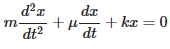

Sendo:


*   m a massa do bloco;
*   u o coeficiente de amortecimento;
*   k a constante elástica da mola;
*   x o deslocamento sofrido pela mola;
*   t o tempo passado.

Se quisermos uma solução única, precisamos aplicar as condições de contorno que, nesse caso, são:

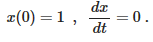




Se lembrarmos do Halliday, a equação para o movimento harmônico simples amortecido é:

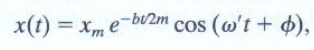

Sendo:



*   Xm a amplitude, representada neste código por 2A, pois as soluções da EDP são raízes complexas e conjugadas (C1 = C2)
*   b o coeficiente de amortecimento, representado por u

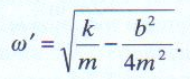

Sendo que o sistema só é amortecido se b <ω, simplificando a equação, chegamos em:

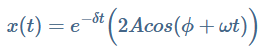

com

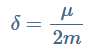
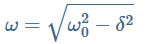


In [ ]:
from PIL import Image
import torch
import torch.nn as nn
from torch.autograd import Variable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from google.colab import files
from google.colab import drive

In [ ]:
def plot_result(x,y,x_data,y_data,y_pred,xp=None):

    plt.figure()
    plt.plot(x,y, color="grey", label="Solução Exata")
    plt.plot(x,y_pred, color="tab:blue", label="Predição Rede Neural")
    plt.scatter(x_data, y_data, s=60, color="tab:red", label='Dados de Treino')
    if xp is not None:
        plt.scatter(xp, -0*torch.ones_like(xp), s=60, color="tab:green", alpha=0.4,
                    label='Physics loss training locations')
    l = plt.legend(loc=(1.01,0.34), frameon=False, fontsize="large")
    plt.setp(l.get_texts(), color="k")
    #plt.xlim(-0.05, 2.1)
    #plt.ylim(-3, 4.1)
    plt.text(1.065,0.7,"Training step: %i"%(i+1),fontsize="xx-large",color="k")
    plt.xlabel('Tempo')
    plt.ylabel('Deslocamento')

In [ ]:
#Construindo os dados de x e y

x = torch.linspace(0,2,1000).view(-1,1) #uma matriz coluna com 1000 valores indo de 0 até 2
m = 1 #Massa unitária em unidades de Kg
d = 3 #delta, deslocamento
w0 = 20 #frequencia natural
w = np.sqrt(w0**2 - d**2)
phi = np.radians(0)
A = 2

cos = torch.cos(phi+w*x) #Cosseno para valores de x
exp = torch.exp(-d*x) #Função exponencial
y = exp*2*A*cos #Valores de altura em função de x

In [ ]:
x_data = x[0:500:40]
y_data = y[0:500:40]

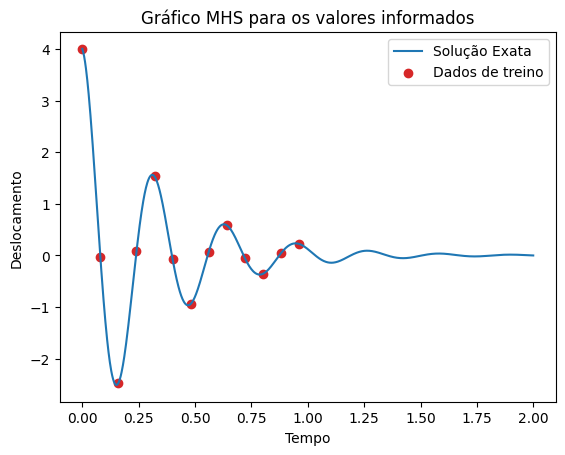

In [ ]:
plt.figure()
plt.plot(x, y, label="Solução Exata")
plt.scatter(x_data, y_data, color="tab:red", label="Dados de treino")
plt.xlabel('Tempo')
plt.ylabel('Deslocamento')
plt.title('Gráfico MHS para os valores informados')
plt.legend()
plt.show()

In [ ]:
#Criando a função para o modelo de rede neural

class modelo_RNA(nn.Module):

    def __init__(self, no_entrada, no_oculto, no_saida, n_camada_oculta):
        super().__init__()
        activation = nn.Tanh
        self.entrada_oculta = nn.Sequential(*[
                        nn.Linear(no_entrada, no_oculto),
                        activation()])
        self.oculta_oculta = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(no_oculto, no_oculto),
                            activation()]) for _ in range(n_camada_oculta)])
        self.oculta_saida = nn.Linear(no_oculto, no_saida)

    def forward(self, x):
        x = self.entrada_oculta(x)
        x = self.oculta_oculta(x)
        x = self.oculta_saida(x)
        return x

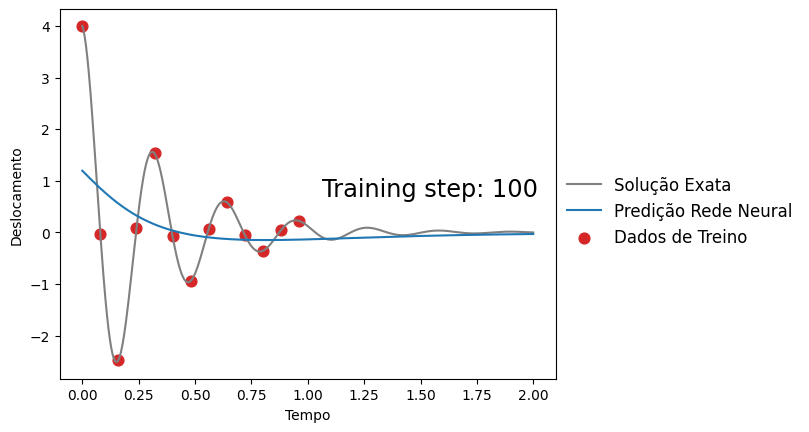

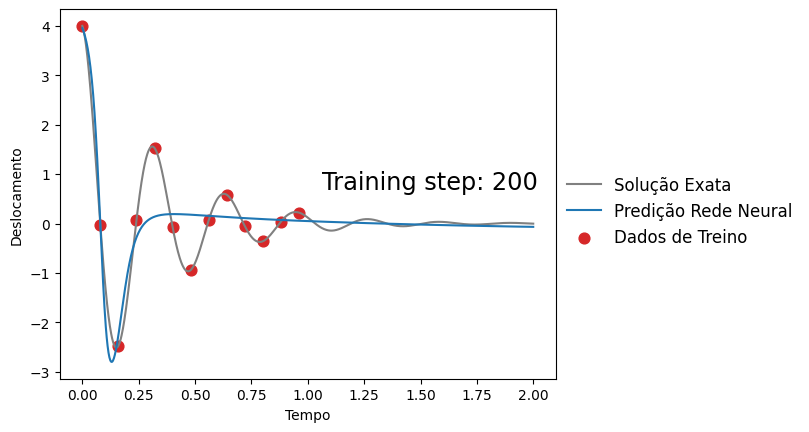

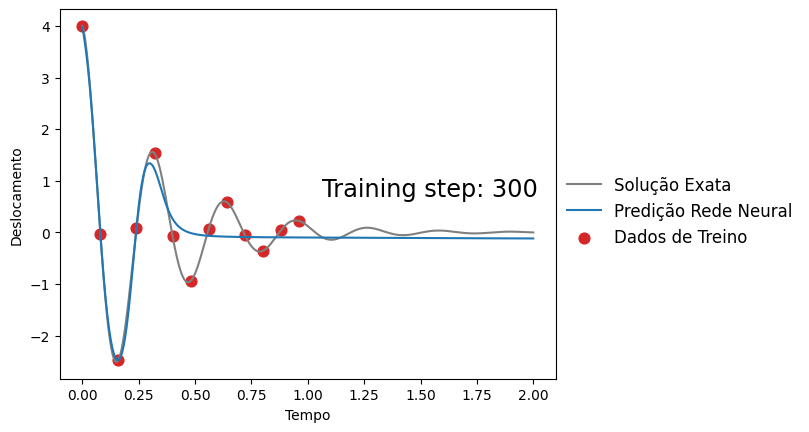

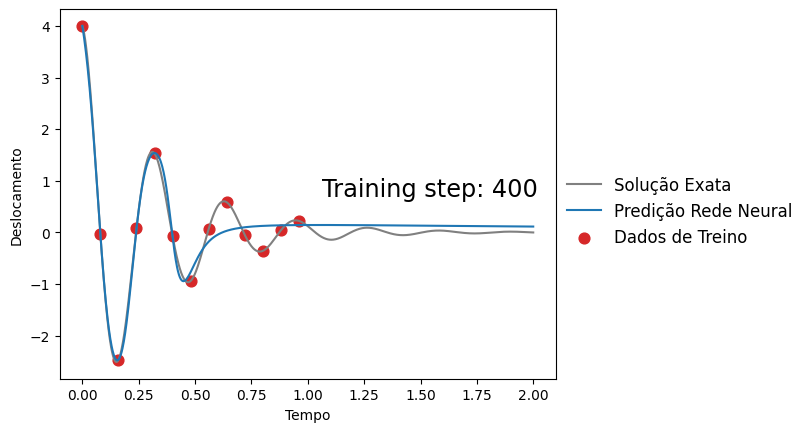

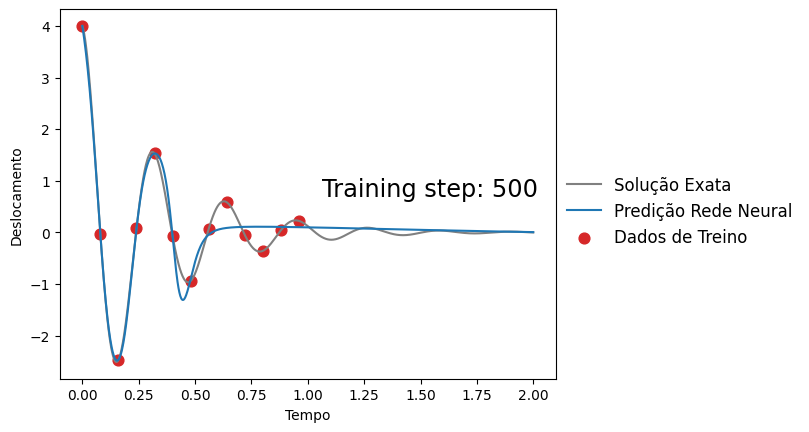

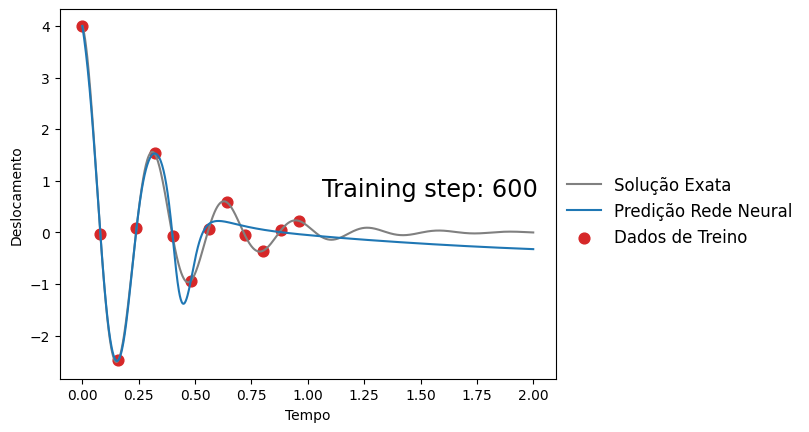

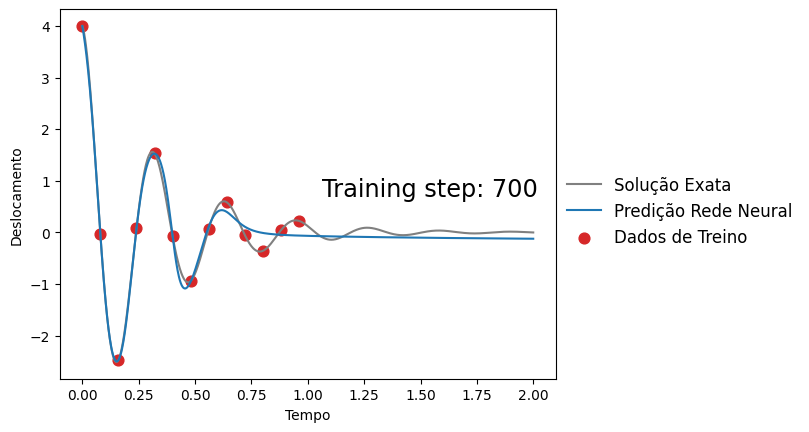

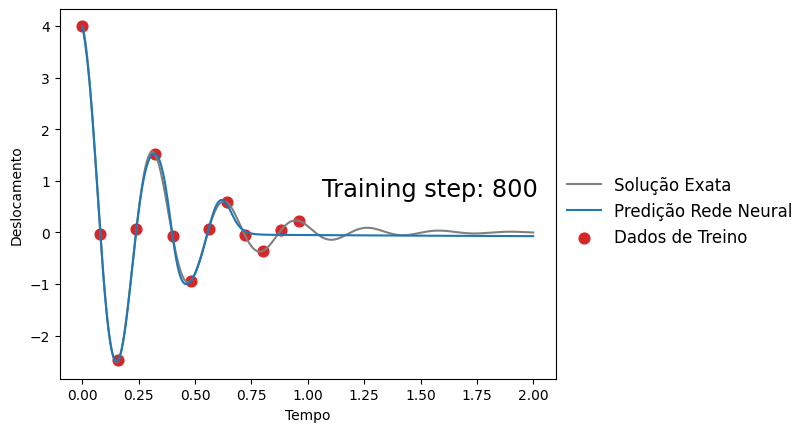

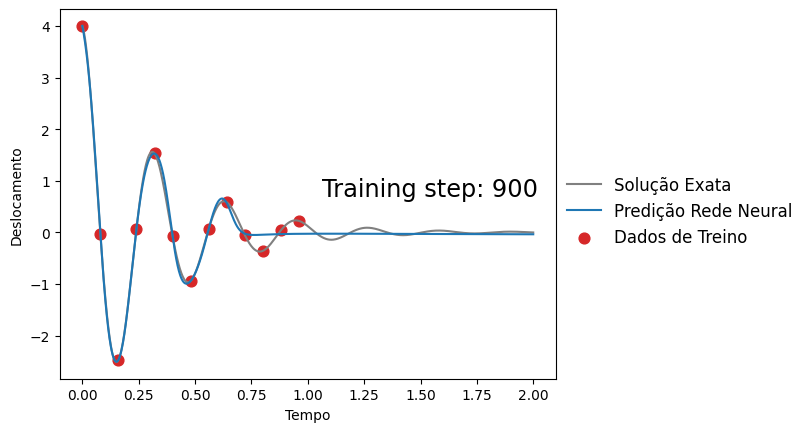

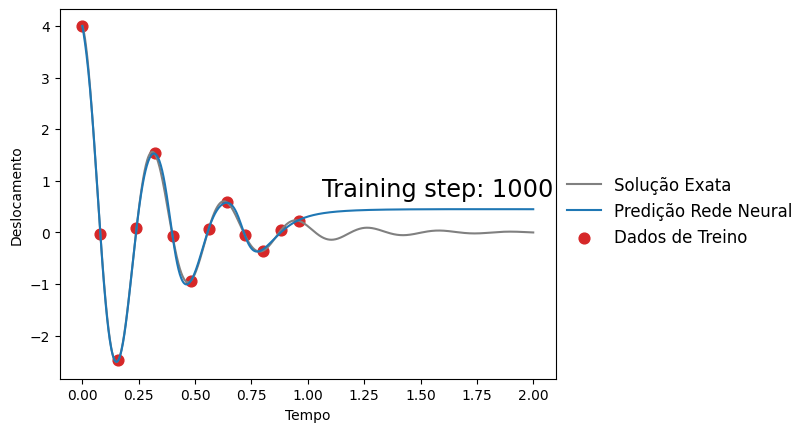

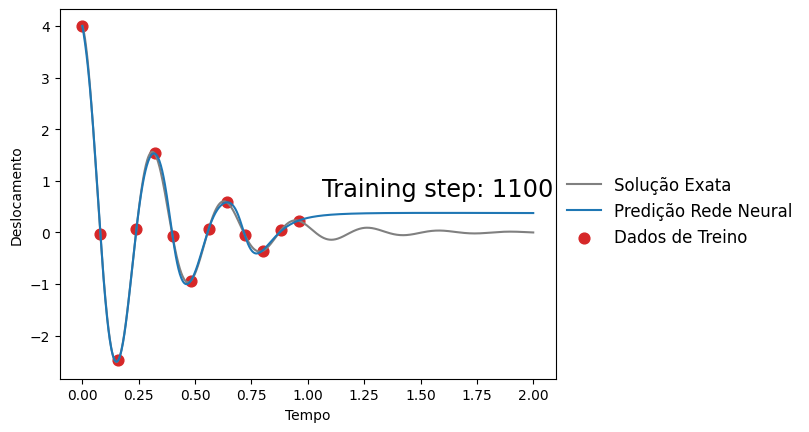

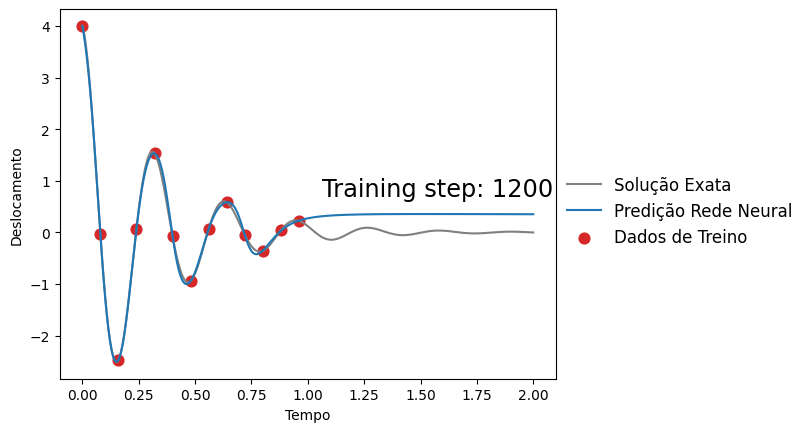

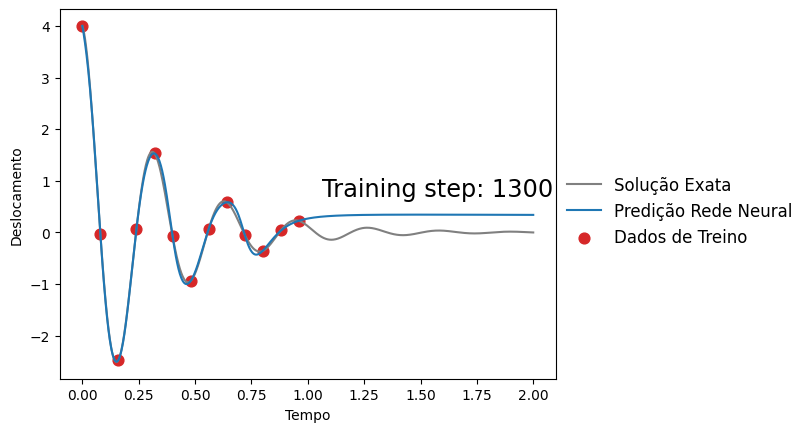

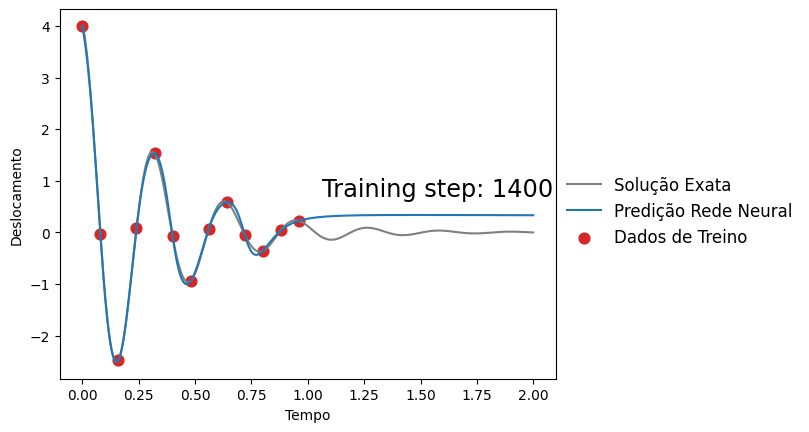

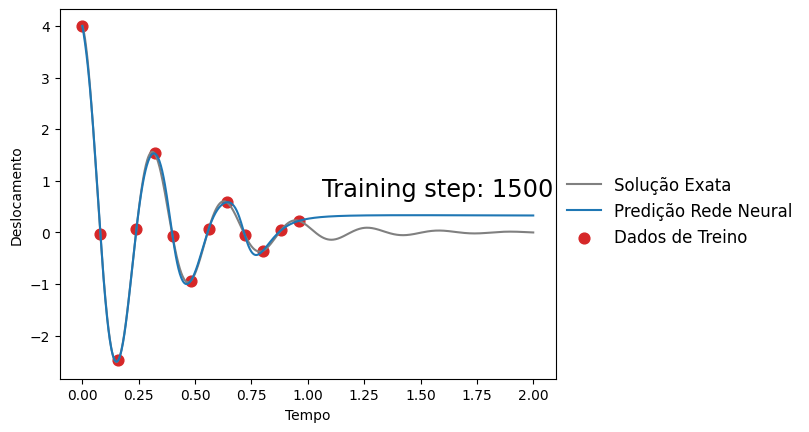

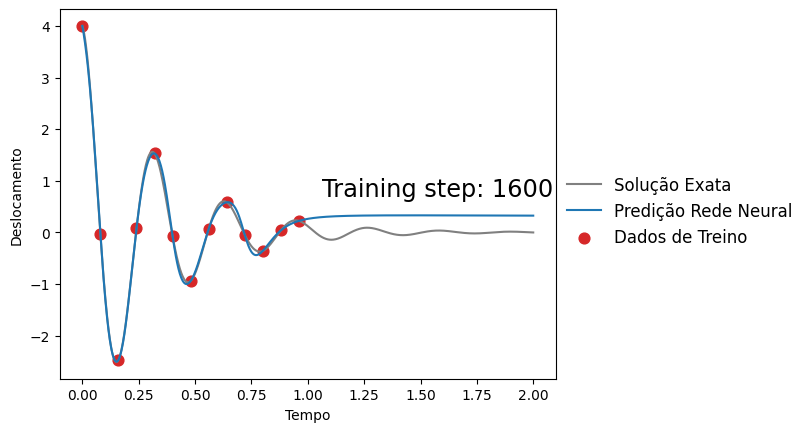

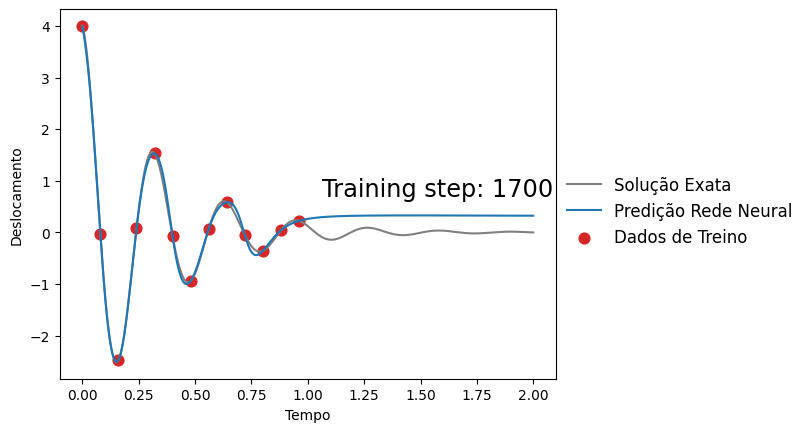

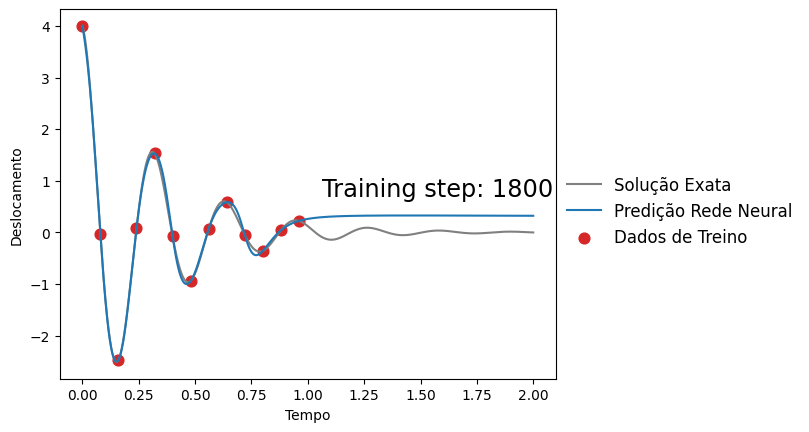

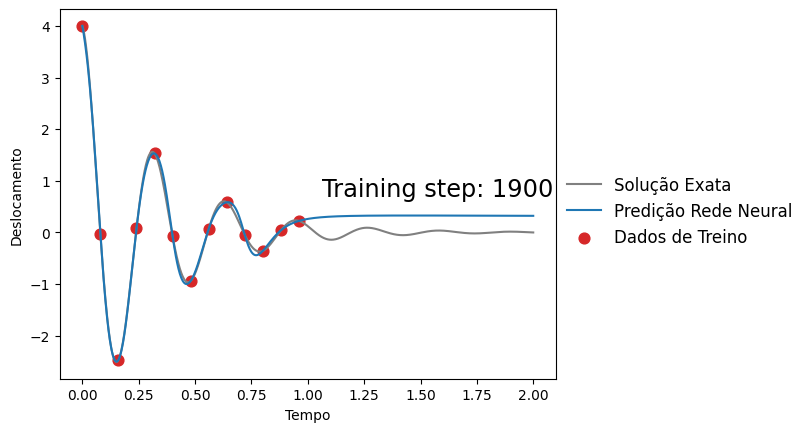

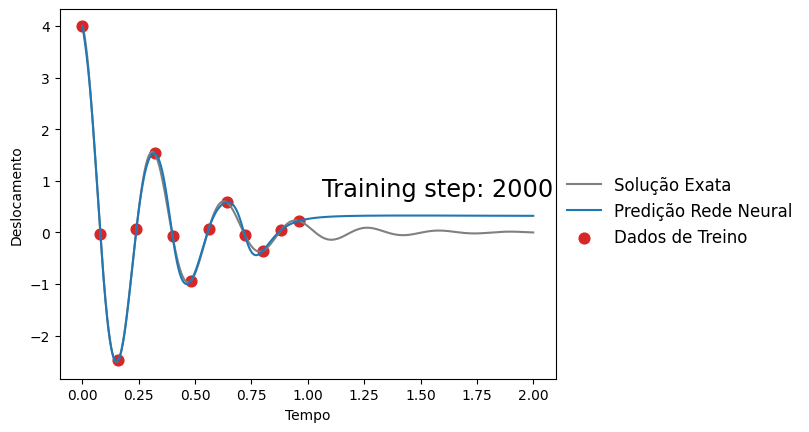

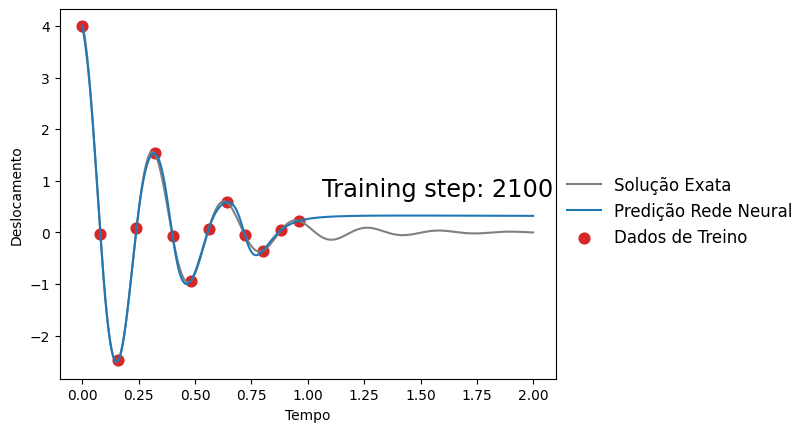

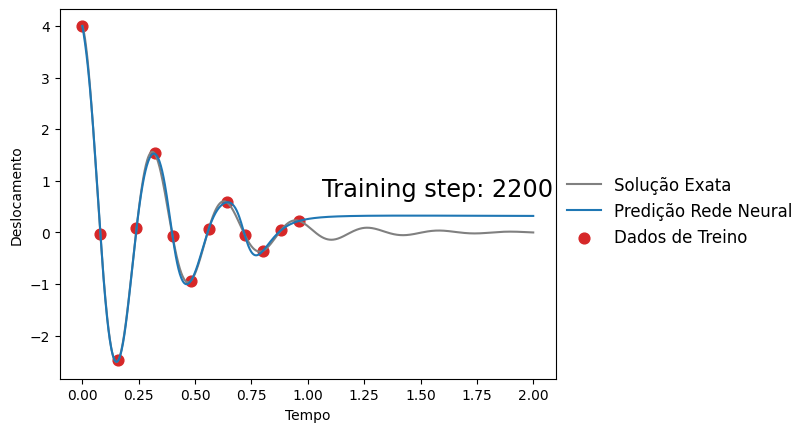

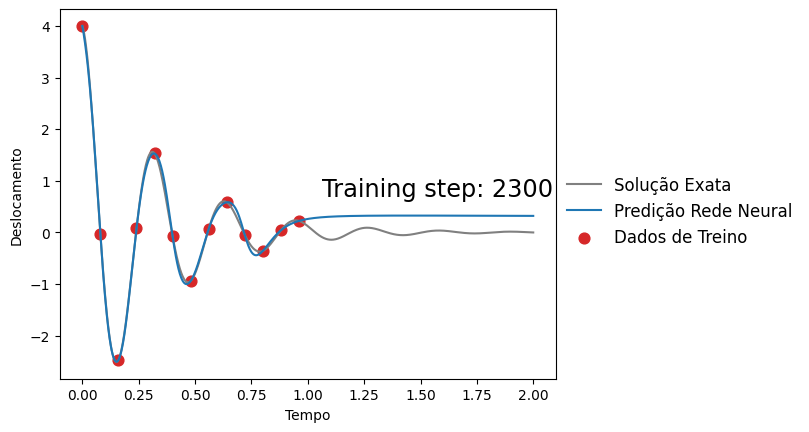

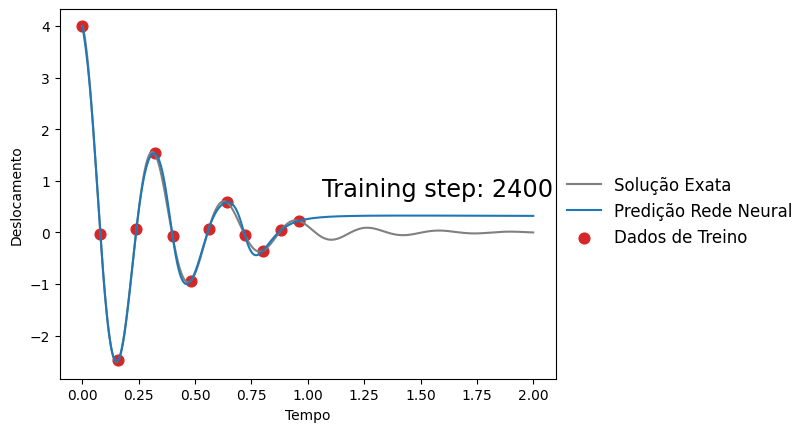

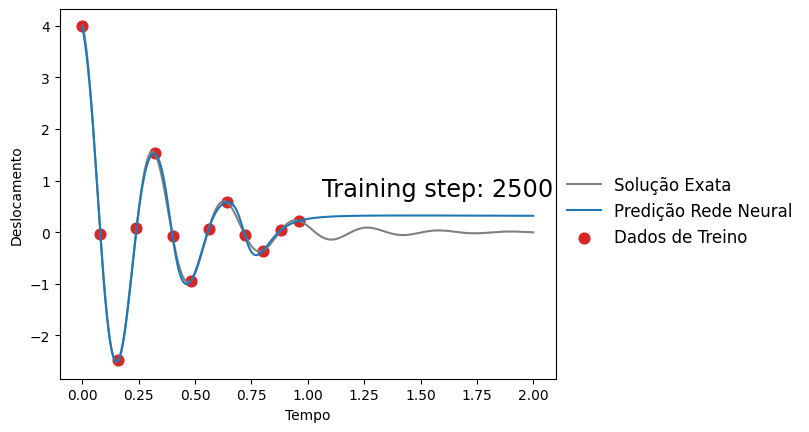

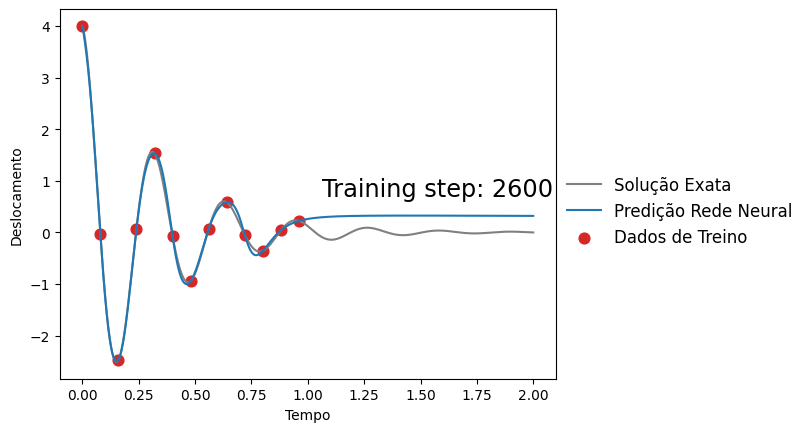

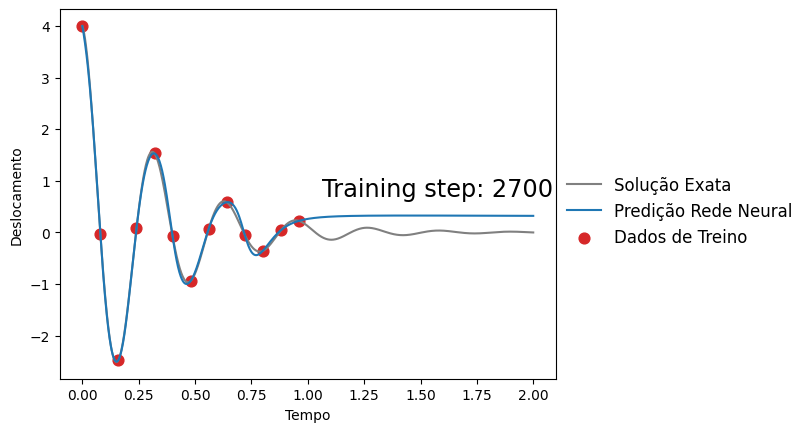

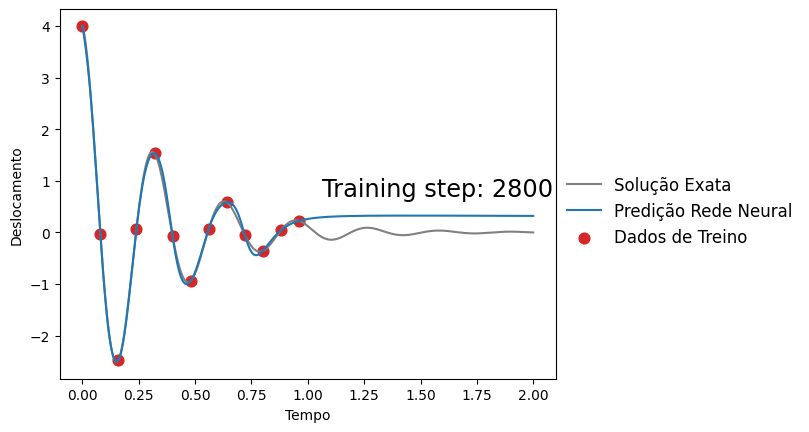

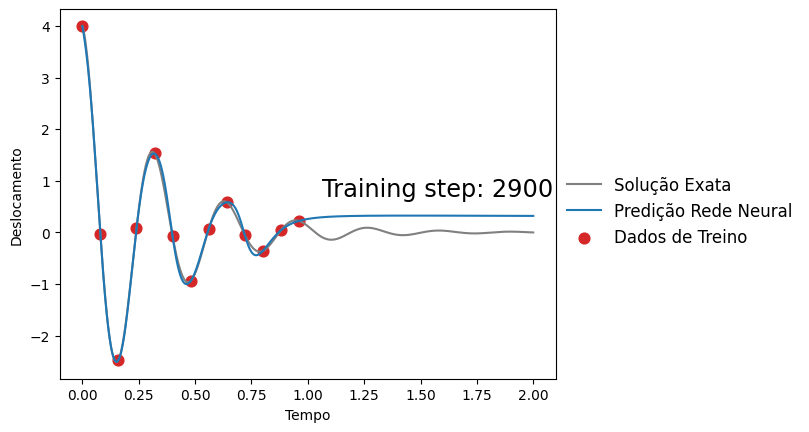

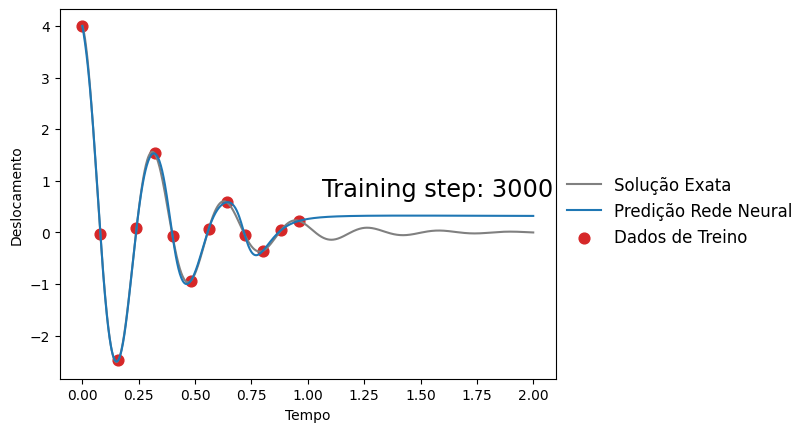

In [ ]:
torch.manual_seed(123) #Padronizando
modelo = modelo_RNA(1, 32, 1, 3)

otimizador = torch.optim.Adam(modelo.parameters(), lr = 0.001)
files = []
for i in range(3000):
  otimizador.zero_grad() #Isso reseta os gradientes corretamente, evitando que ele seja uma combinação de algum fradiente antigo
  y_pred = modelo(x_data)
  loss = torch.mean((y_pred - y_data)**2) #Fórmula do MSE
  loss.backward() #Calcula e armazena os gradientes com base no backpropagation
  otimizador.step() #Atualiza os parâmetros do modelo com base nos gradientes
  if (i+1) % 10 == 0:

    y_pred = modelo(x).detach()
    plot_result(x,y,x_data,y_data,y_pred)
    files.append(plt.savefig('tentando.png', bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white"))
    #files.append('tentando.png')

    if (i+1) % 100 == 0: plt.show()
    else: plt.close("all")

In [ ]:
class modelo1(nn.Module):

    def __init__(self, no_entrada, no_oculto, no_saida, n_camada_oculta):
        super().__init__()
        activation = nn.Tanh
        self.entrada_oculta = nn.Sequential(*[
                        nn.Linear(no_entrada, no_oculto),
                        activation()])
        self.oculta_oculta = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(no_oculto, no_oculto),
                            activation()]) for _ in range(n_camada_oculta)])
        self.oculta_saida = nn.Linear(no_oculto, no_saida)

    def forward(self, x):
        x = self.entrada_oculta(x)
        x = self.oculta_oculta(x)
        x = self.oculta_saida(x)
        return x

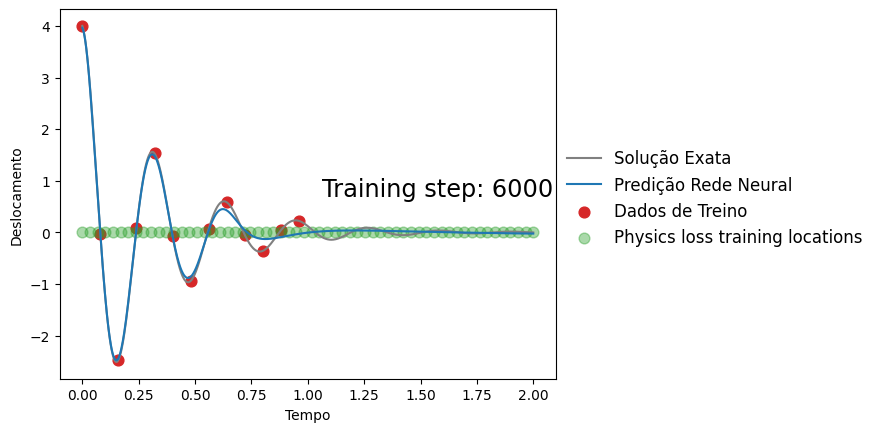

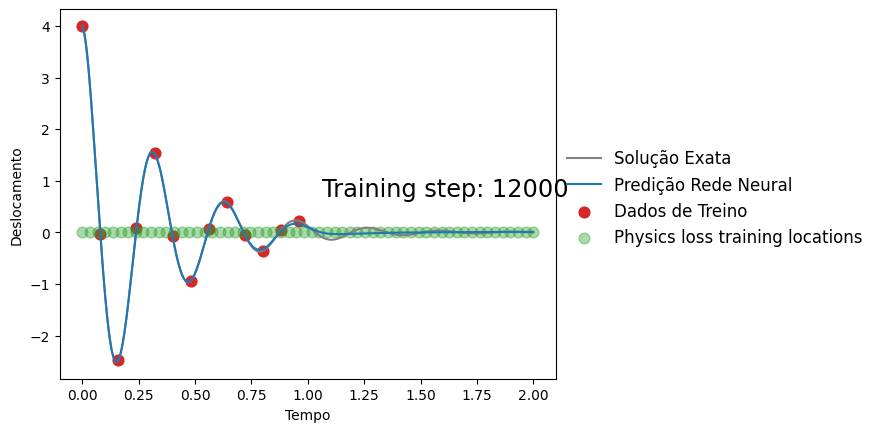

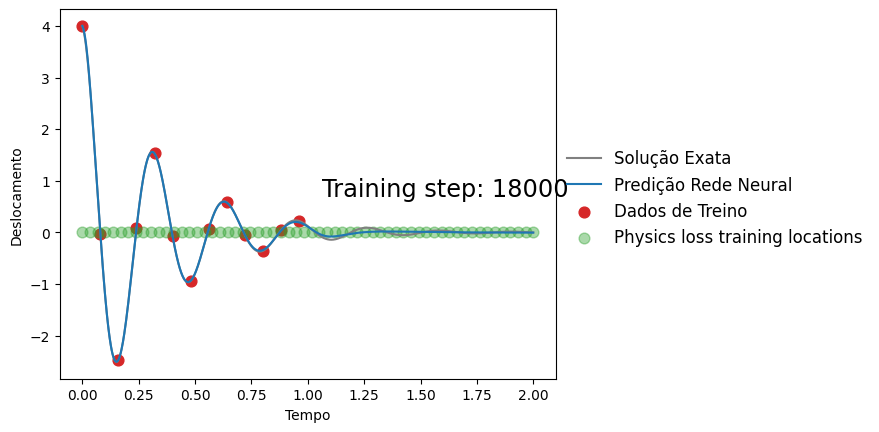

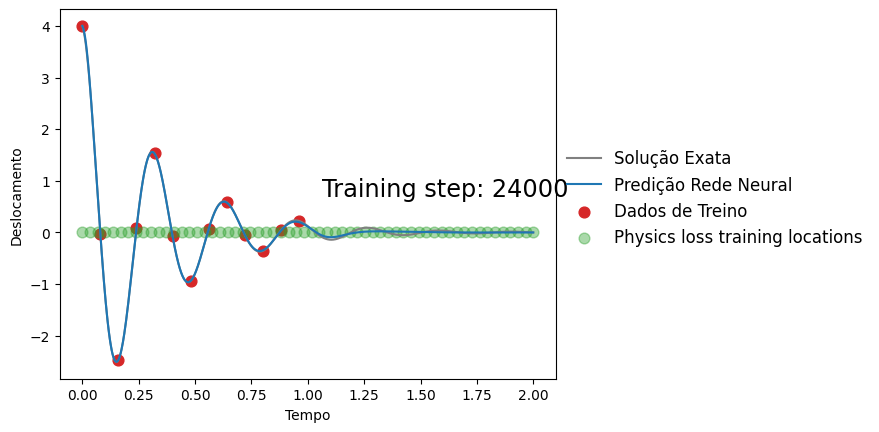

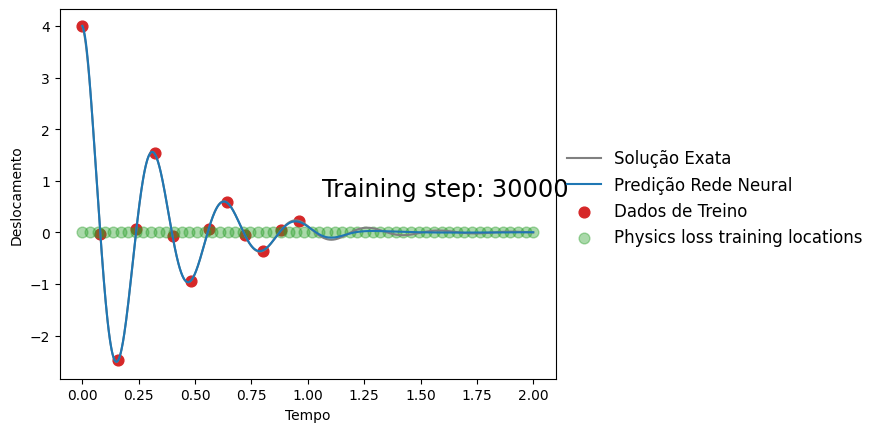

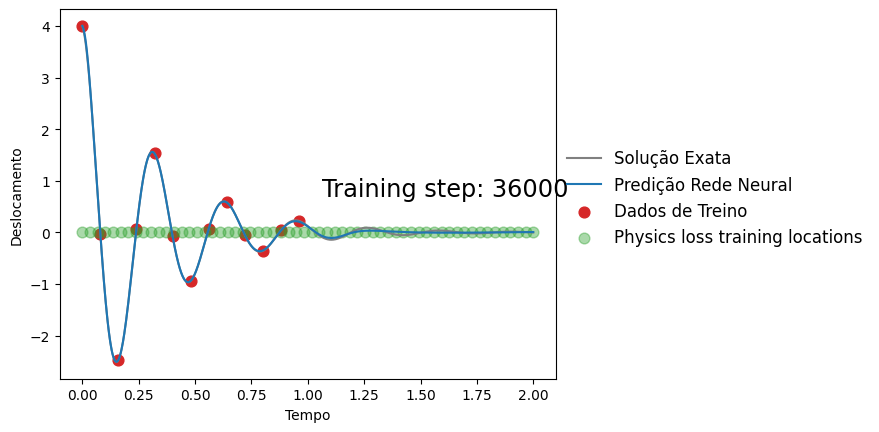

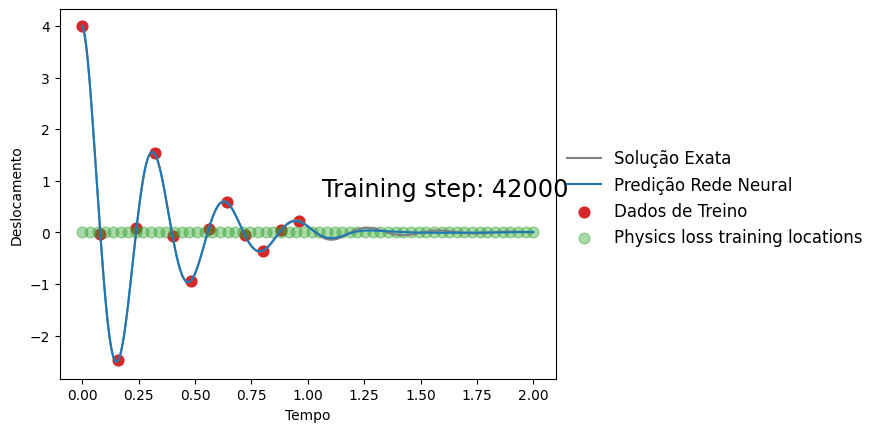

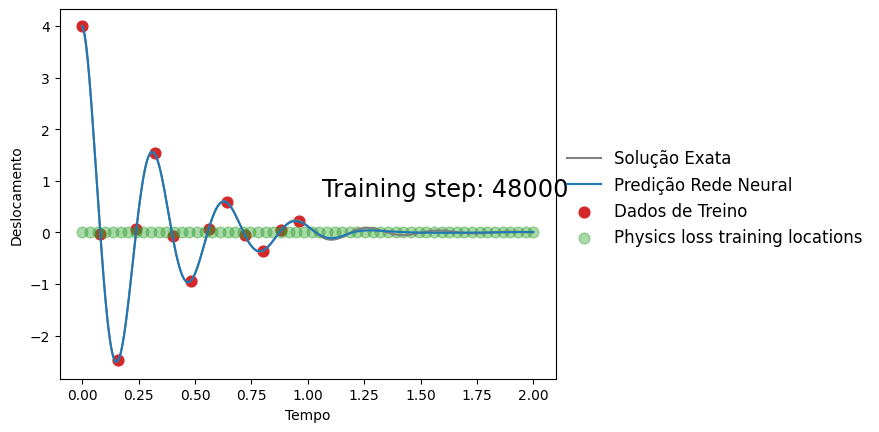

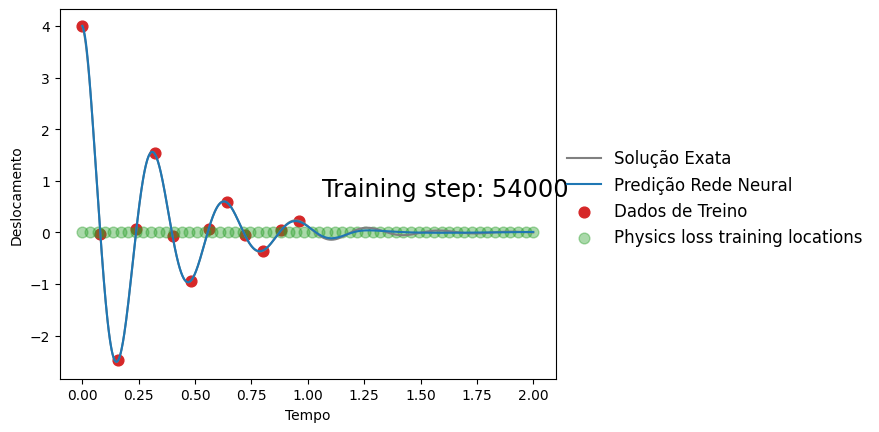

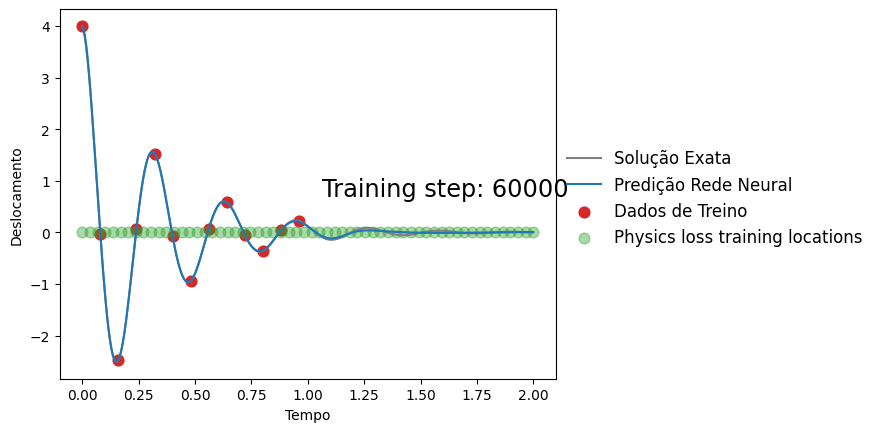

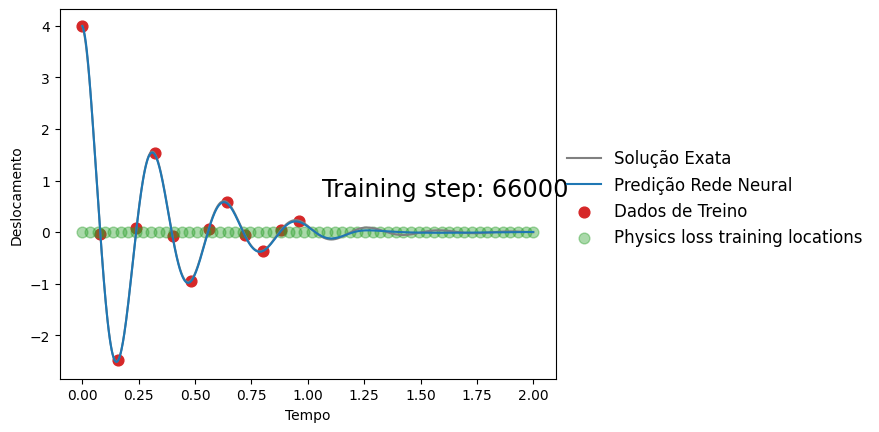

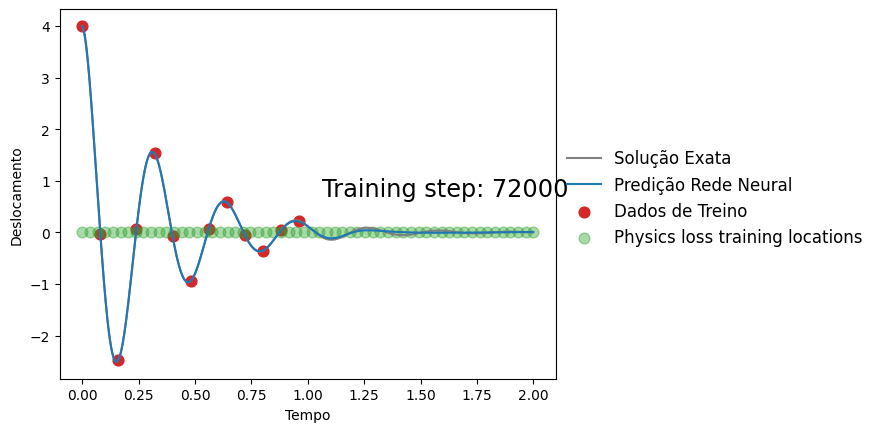

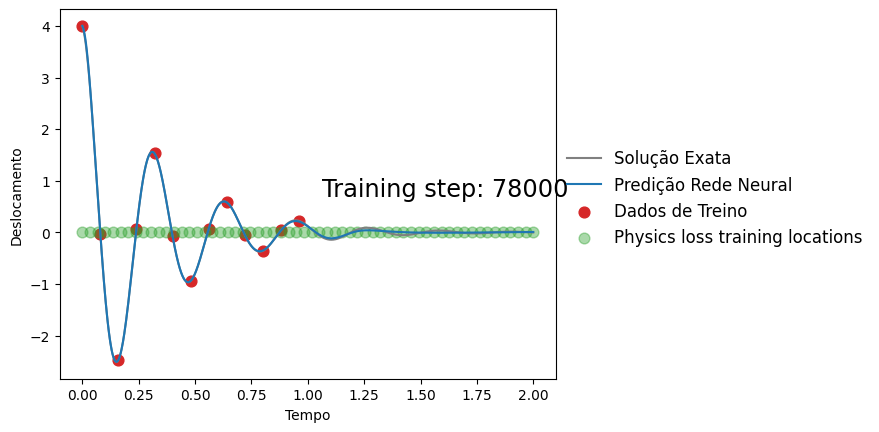

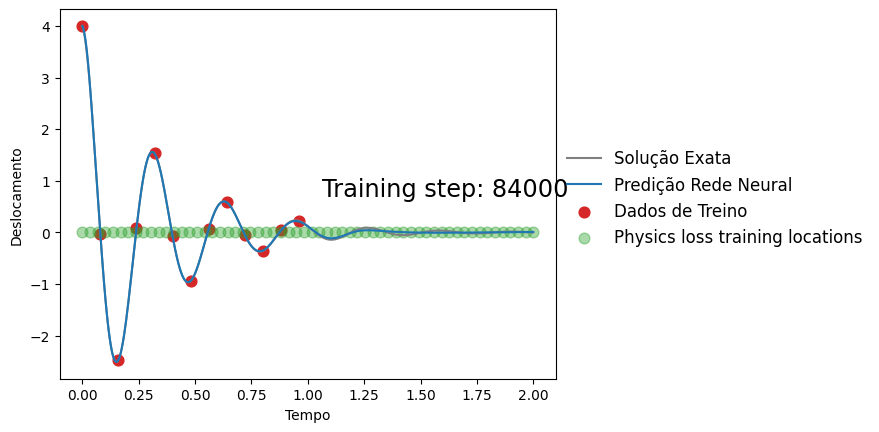

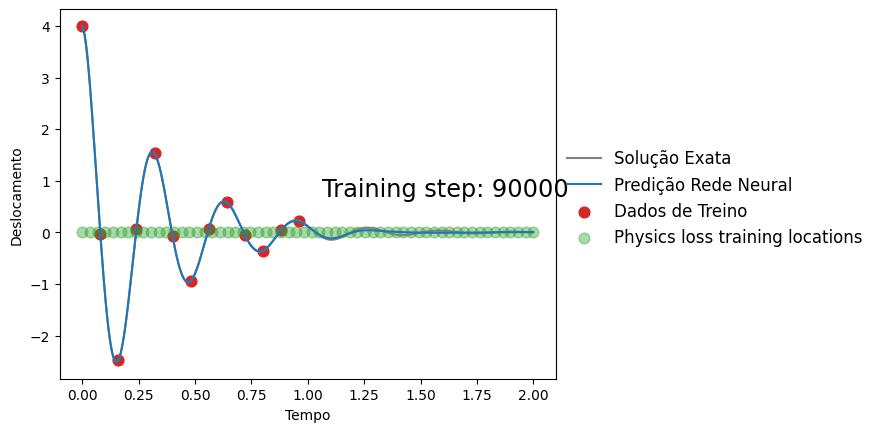

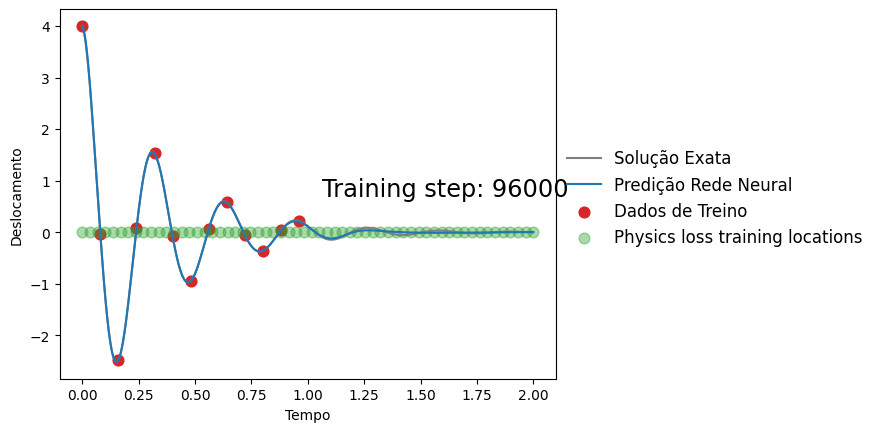

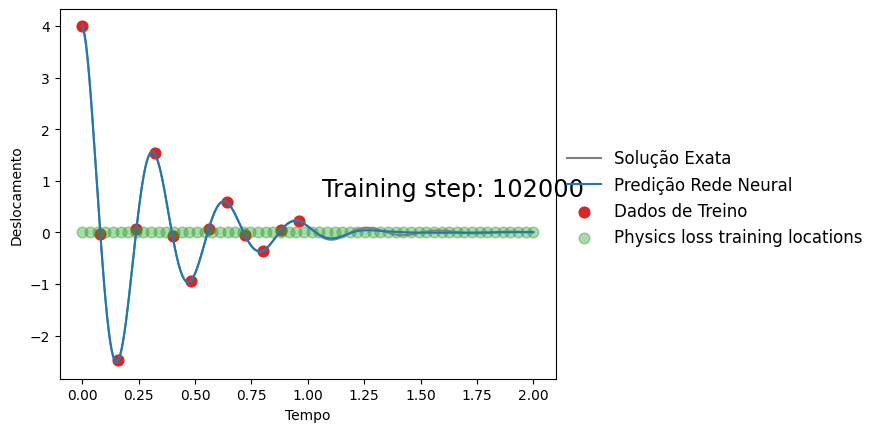

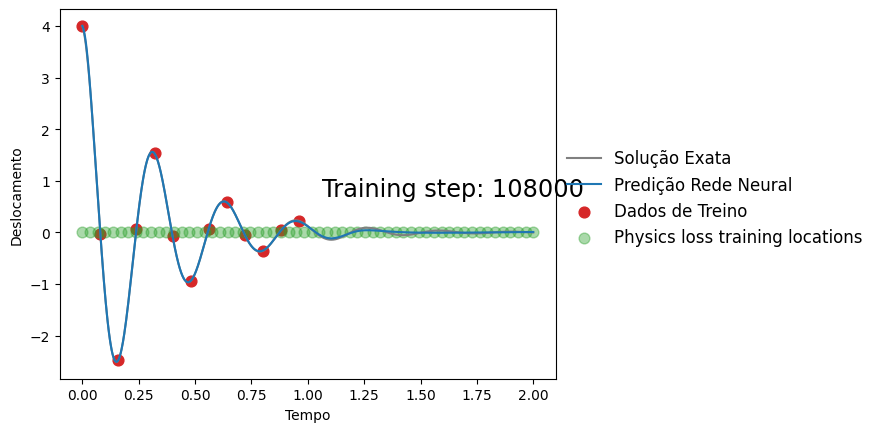

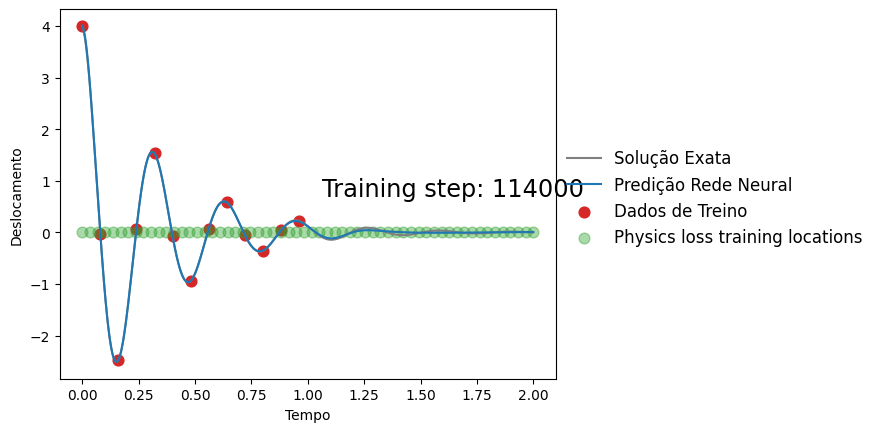

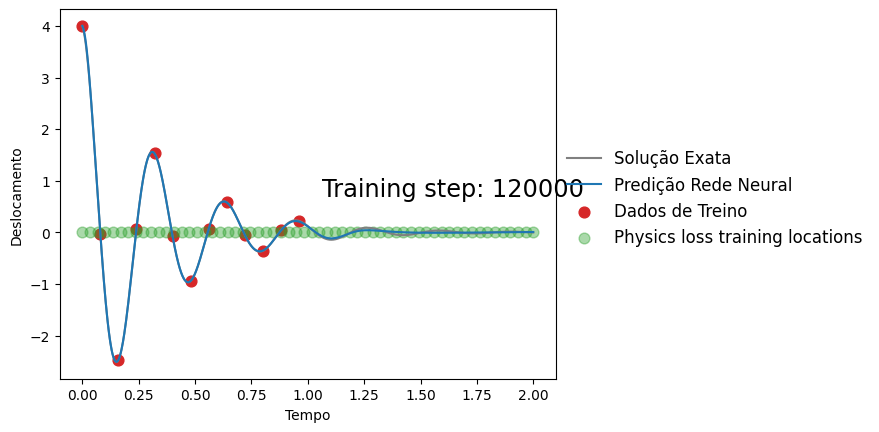

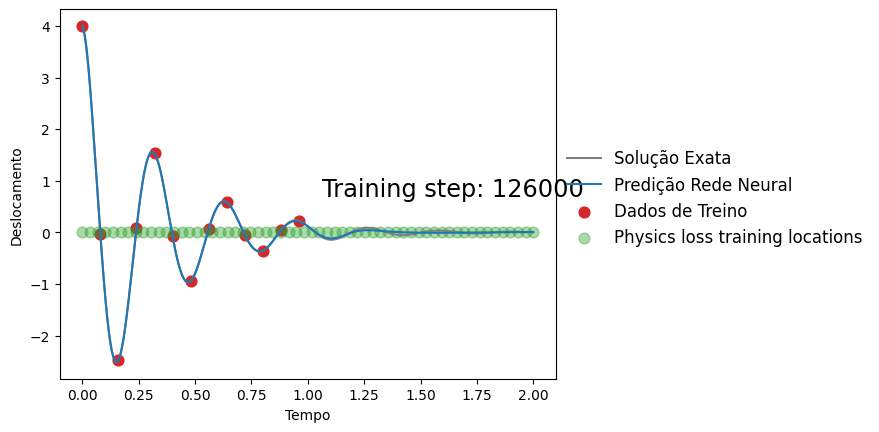

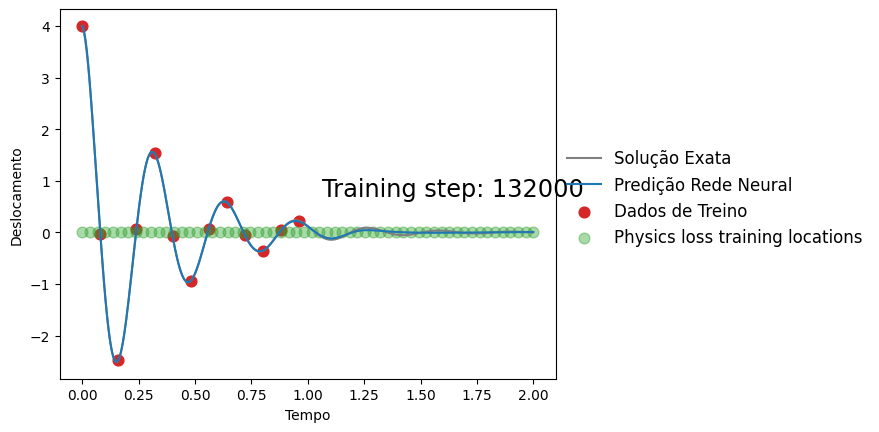

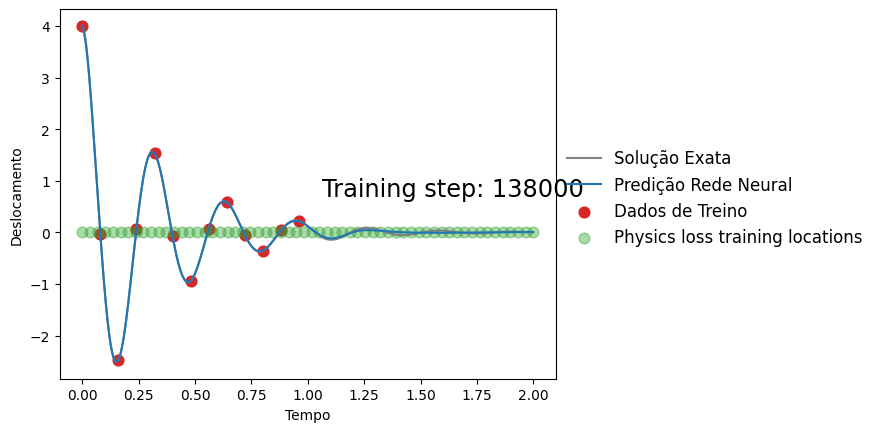

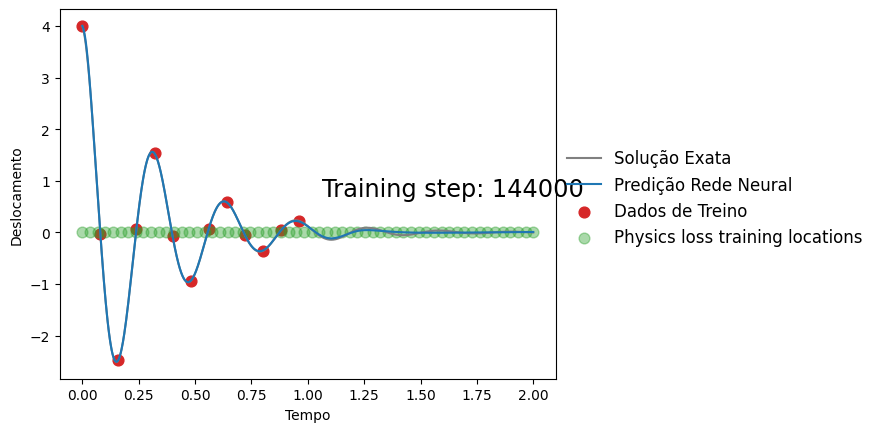

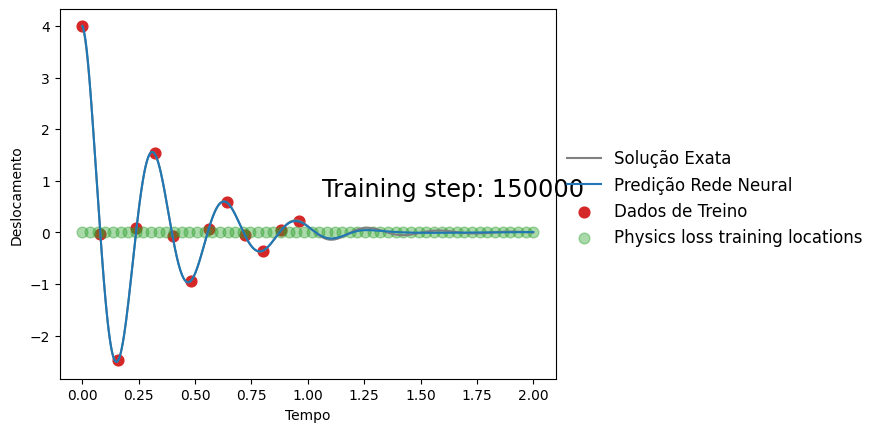

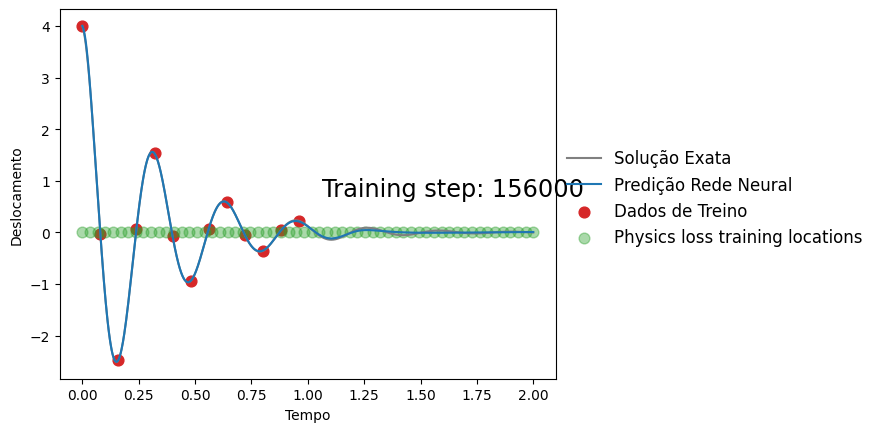

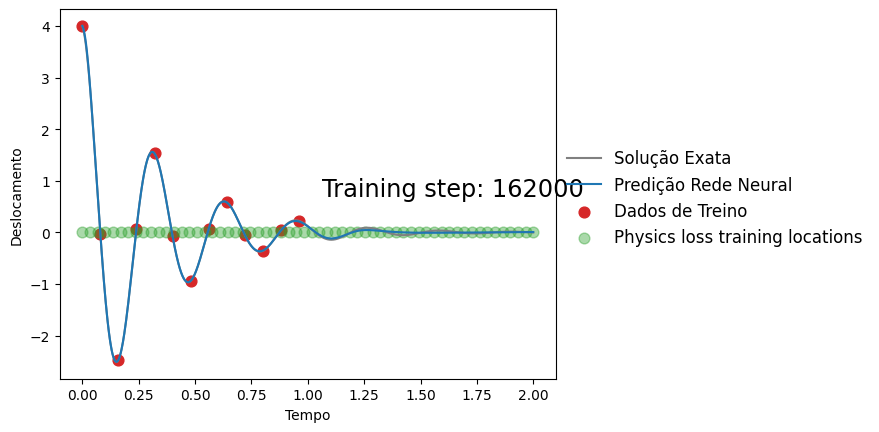

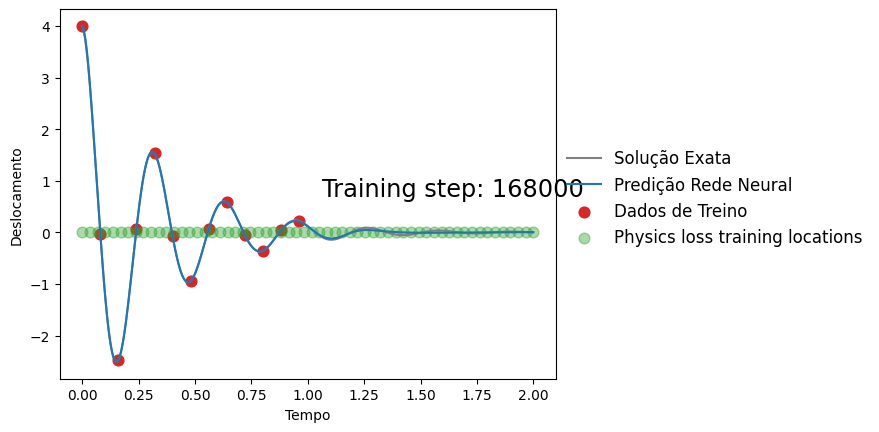

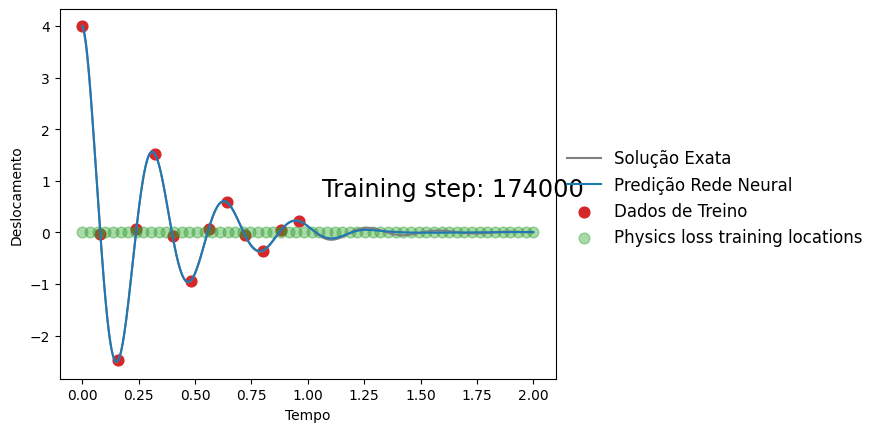

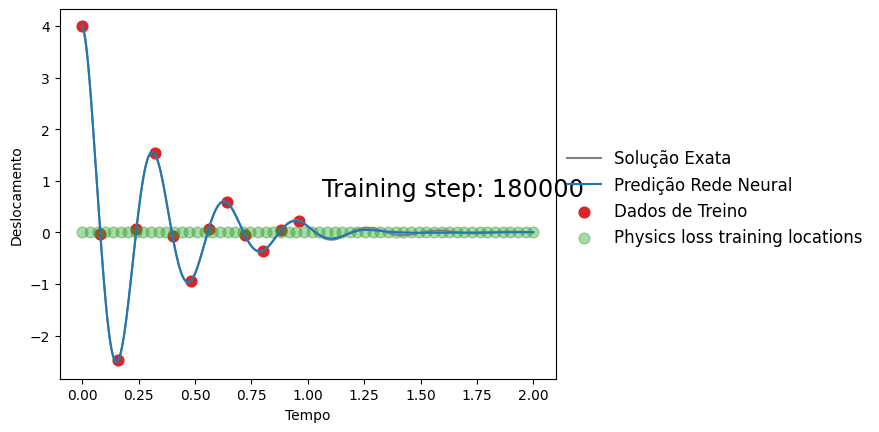

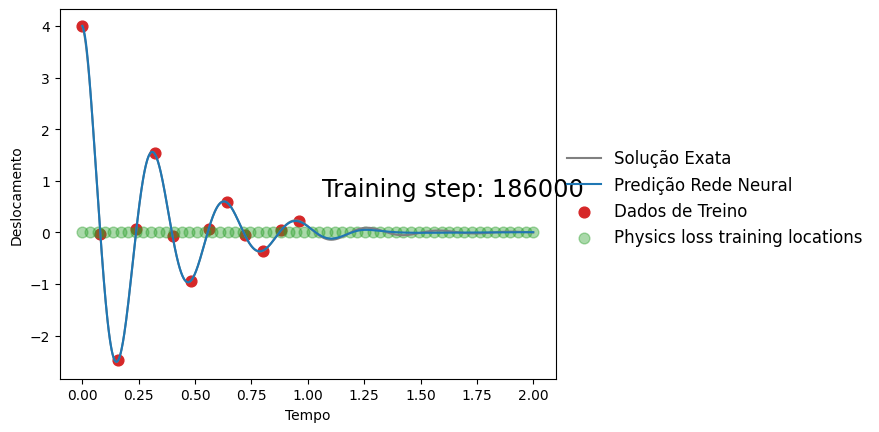

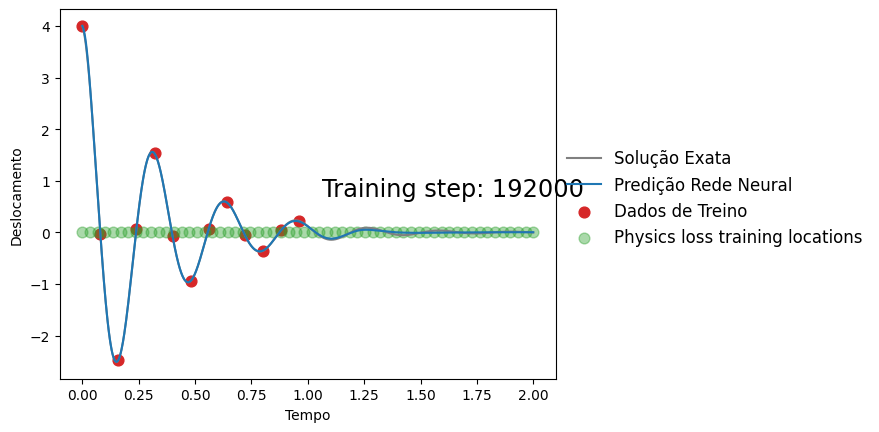

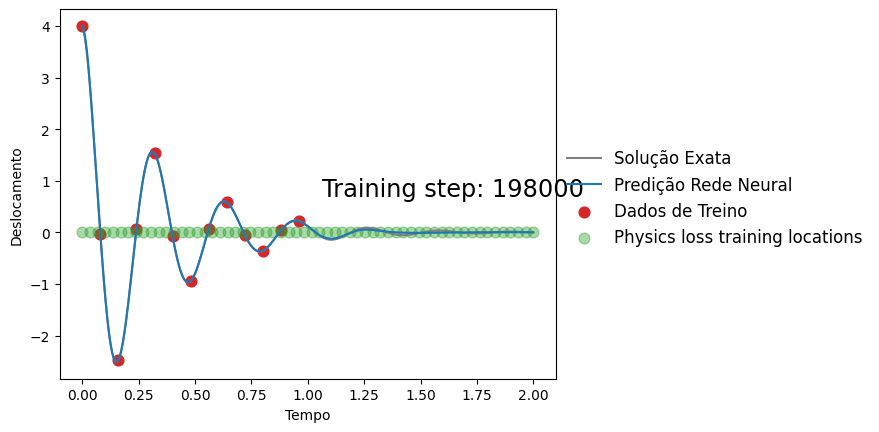

In [ ]:
x_fisica = torch.linspace(0,2,60).view(-1,1).requires_grad_(True)
mi = 2*d*m
k = (w0**2)*m

torch.manual_seed(123)
modelo = modelo1(1,32,1,3)
otimizador = torch.optim.Adam(modelo.parameters(),lr=1e-4)

for i in range(200000):
    otimizador.zero_grad()
    y_pred = modelo(x_data)
    loss1 = torch.mean((y_pred-y_data)**2) #MSE da função

    #Custo para função física
    y_predfisica = modelo(x_fisica)
    dx  = torch.autograd.grad(y_predfisica, x_fisica, torch.ones_like(y_predfisica), create_graph=True)[0]#gradiente dy/dx
    dx2 = torch.autograd.grad(dx,  x_fisica, torch.ones_like(dx),  create_graph=True)[0]#gradiente d^2y/dx^2
    physics = dx2 + mi*dx + k*y_predfisica #calculando o valor segundo a fisica
    loss2 = (1e-4)*torch.mean(physics**2)

    #Backpropagation
    loss = loss1 + loss2
    loss.backward()
    otimizador.step()

    if (i+1) % 150 == 0:

        y_pred = modelo(x).detach()
        xp = x_fisica.detach()

        plot_result(x,y,x_data,y_data,y_pred,xp)
        files.append(plt.savefig('seila.png', bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white"))

        if (i+1) % 6000 == 0: plt.show()
        else: plt.close("all")